Dropped 11 rows with missing PM2.5 values.
Final dataset size: 109 rows
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2171 - val_loss: 0.2864
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1219 - val_loss: 0.1149
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0518 - val_loss: 0.0846
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0476 - val_loss: 0.0851
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0455 - val_loss: 0.0711
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0388 - val_loss: 0.0736
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0421 - val_loss: 0.0748
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0350 - val_loss: 0.0721
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0362 - val_loss: 0.0653
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0338 - val_loss: 0.0609
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0320 - val_loss: 0.0577
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0346 - val_loss: 0.0559
Epoch 13/50


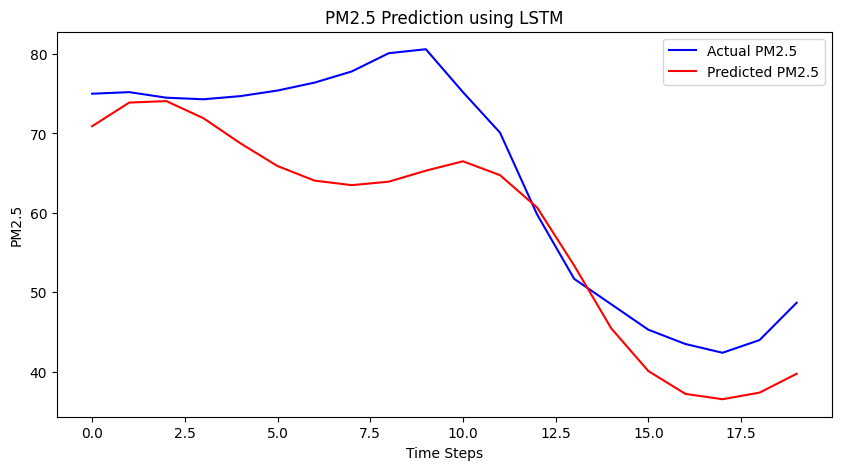

In [1]:
# =======================
# LSTM for PM2.5 Prediction
# =======================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =======================
# 1. Load and preprocess dataset
# =======================
df = pd.read_csv('kanpur.csv')

# Convert datetime column
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# Handle missing or invalid values in PM2.5
df['PM2.5'] = pd.to_numeric(df['PM2.5'], errors='coerce')
missing_before = df['PM2.5'].isna().sum()
df = df.dropna(subset=['PM2.5'])
print(f"Dropped {missing_before} rows with missing PM2.5 values.")
print(f"Final dataset size: {len(df)} rows")

# Use only PM2.5 values for time series
data = df[['PM2.5']].values

# Normalize data (LSTM converges faster)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# =======================
# 2. Create sequences (look_back)
# =======================
def create_dataset(dataset, look_back=10):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10  # number of previous time steps to use
X, y = create_dataset(data_scaled, look_back)

# Reshape input to [samples, timesteps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# =======================
# 3. Train-test split (80/20)
# =======================
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# =======================
# 4. Build and compile LSTM model
# =======================
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# =======================
# 5. Train the model
# =======================
history = model.fit(
    X_train, y_train,
    epochs=50,             # Number of passes over entire training data
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

# =======================
# 6. Make predictions
# =======================
y_pred = model.predict(X_test)

# Inverse transform back to original PM2.5 scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# =======================
# 7. Compute evaluation metrics
# =======================
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("\n📊 Evaluation Metrics:")
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# =======================
# 8. Plot Actual vs Predicted
# =======================
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual PM2.5', color='blue')
plt.plot(y_pred_inv, label='Predicted PM2.5', color='red')
plt.title('PM2.5 Prediction using LSTM')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()
